In [1]:
#Imports
import json
import numpy as np
import pandas as pd
import csv
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
from django.contrib.admin.utils import flatten
import pyhrv
import pyhrv.nonlinear as nl
import statistics
from scipy.stats.stats import pearsonr 

In [2]:
# Calcula el std de los mínimos porcentuales

path = 'C:/Users/Leand/OneDrive/Documentos/Lean/Analizador_imagenes_calcio/Luis/'
# path = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/'
experiments = os.listdir(path + 'jsons/')
min_exp = pd.DataFrame()
for i in range(0,len (experiments)):
    experiment = experiments[i]
    with open(path + 'jsons/' + experiment) as f:
        min_file = json.load(f)['image']['min_peaks_intensities']
        min_exp[i] = experiment,(np.array(min_file)*100/min_file[0]).std()
min_exp = pd.DataFrame (min_exp.T)
min_exp.columns = ['file','std_min']

In [172]:
# Extrae los mínimos por slice

path = 'C:/Users/Leand/OneDrive/Documentos/Lean/Analizador_imagenes_calcio/Luis/'
# path = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/'
experiments = os.listdir(path + 'jsons/')
min_exp = pd.DataFrame()
for i in range(0,len (experiments)):
    experiment = experiments[i]
    with open(path + 'jsons/' + experiment) as f:
        min_file = json.load(f)['image']['min_peaks_intensities']
        min_exp[i] = experiment,(np.array(min_file)*100/min_file[0])
min_exp = pd.DataFrame (min_exp.T)
min_exp.columns = ['file','mins']

In [173]:
# Filtrado por tratamiento y frecuencia

def tau_filter(tratamiento,frecuencia,df):
    tabulado_filter = tabulado[(tabulado['tratamiento']==tratamiento) & (tabulado['frecuencia']== frecuencia)].reset_index(drop=True)
    tau = pd.DataFrame(columns = ['file','mins'])
    for j in range(0,len (tabulado_filter)):
        celula = tabulado_filter['célula'][j]
        foto = tabulado_filter['foto'][j][:-4]
        for i in range(0,len (df)):
            if (celula in df['file'][i]) & (foto in df['file'][i]):
                tau.loc[j] = df.loc[i]
    return tau

In [174]:
path = 'C:/Users/Leand/OneDrive/Documentos/Lean/Analizador_imagenes_calcio/Luis/analisis/'
tabulado = pd.read_csv(path + 'tabulado')
del tabulado['Unnamed: 0']

In [175]:
tabulado_control5 = tau_filter('C', 5, min_exp)
tabulado_vk5 = tau_filter('VK', 5, min_exp)
tabulado_dan5 = tau_filter('DAN', 5, min_exp)

In [176]:
tabulado_control5 = tabulado_control5.reset_index(drop=True)
tabulado_vk5 = tabulado_vk5.reset_index(drop=True)
tabulado_dan5 = tabulado_dan5.reset_index(drop=True)

In [7]:
tabulado_control5.drop(3, inplace=True)

In [113]:
def outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    idx = ~((column < (Q1 - 1.5 * IQR)) | (column > (Q3 + 1.5 * IQR)))
    return idx

In [10]:
tabulado_control5 = tabulado_control5[outliers(tabulado_control5['std_min'])]
tabulado_vk5 = tabulado_vk5[outliers(tabulado_vk5['std_min'])]
tabulado_dan5 = tabulado_dan5[outliers(tabulado_dan5['std_min'])]

KeyError: 'std_min'

ValueError: min() arg is an empty sequence

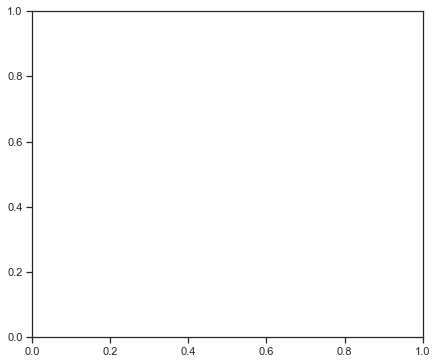

In [37]:
df = pd.concat ([tabulado_control5,tabulado_vk5,tabulado_dan5], axis=1, sort=False, keys=['C', 'VK','DAN'])
df
sns.set(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))


sns.boxplot(data=df)

sns.swarmplot(data=df, linewidth=2)
f.savefig("std_min%.png")

In [ ]:
df.to_excel('std_min%.xlsx', engine = 'xlsxwriter')

In [ ]:
print(scipy.stats.kstest(tabulado_control5['std_min'],tabulado_dan5['std_min']))
print(scipy.stats.kstest(tabulado_control5['std_min'],tabulado_vk5['std_min']))
print(scipy.stats.kstest(tabulado_vk5['std_min'],tabulado_dan5['std_min']))
print(scipy.stats.shapiro(tabulado_control5['std_min']))

In [ ]:
DI_control = pd.read_csv(path + 'DI_control.csv')

In [ ]:
min5 = []
for i in range(0,len(DI_control['file'])):
    cel = DI_control['file'][i]
    filtro_wc5 = tabulado_control5[(tabulado_control5['file'].str.contains(cel) == True)]
    min5.append (filtro_wc5['std_min'].values)
DI_control['min5'] = min5

In [ ]:
DI_control.drop(4, inplace=True)
DI_control.drop(5, inplace=True)
DI_control.drop(6, inplace=True)
DI_control.drop(9, inplace=True)
DI_control.drop(21, inplace=True)
b = [j for i in DI_control['min5'].tolist() for j in i]
a = DI_control['DISCORDANCE 5 Hz']

In [ ]:
from scipy.stats.stats import pearsonr 
print (pearsonr(DI_control['DISCORDANCE 5 Hz'],b))

In [ ]:
plt.scatter(a,b)

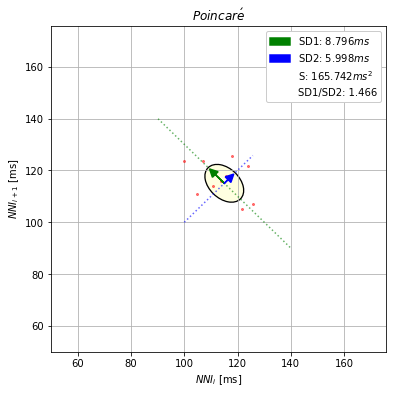

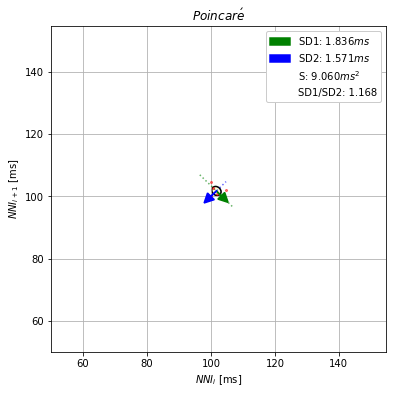

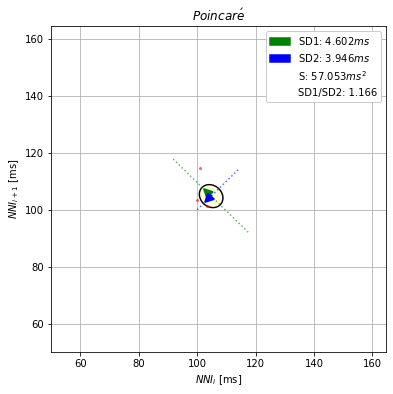

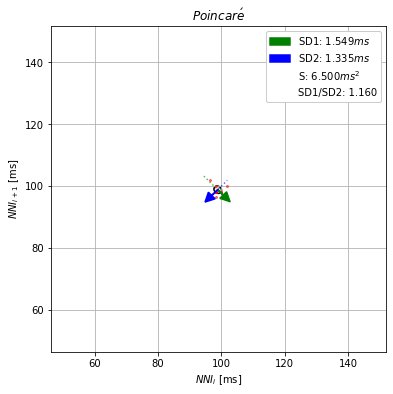

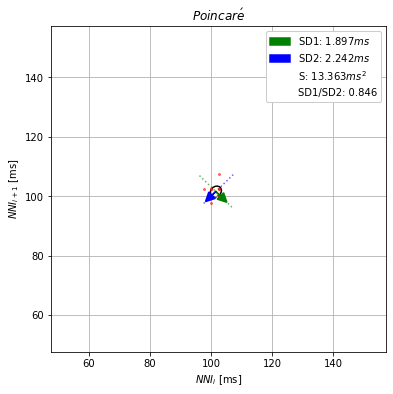

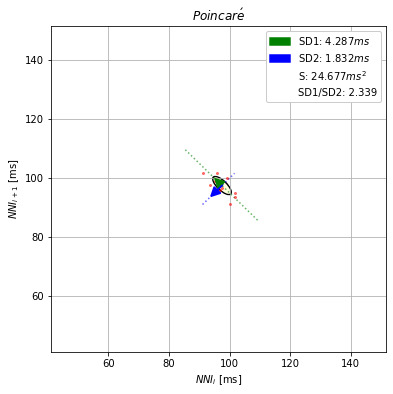

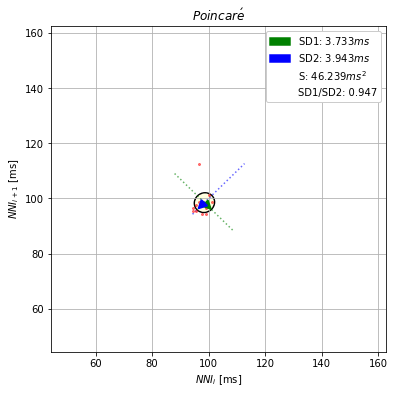

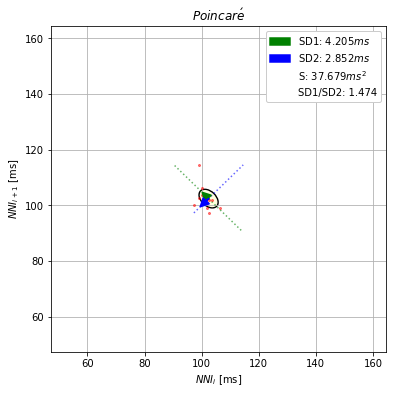

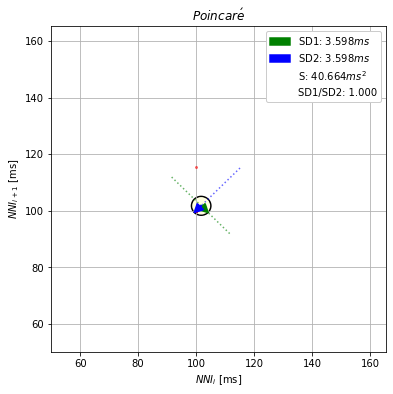

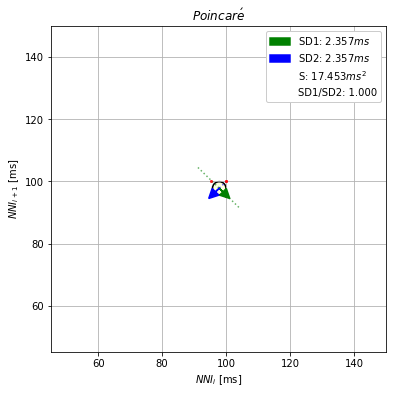

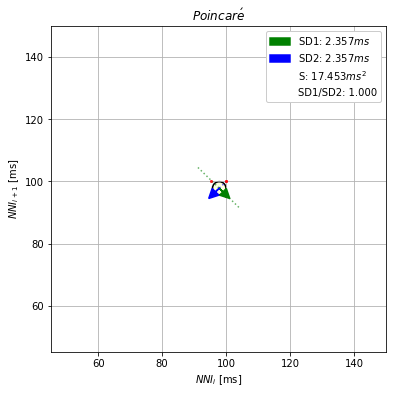

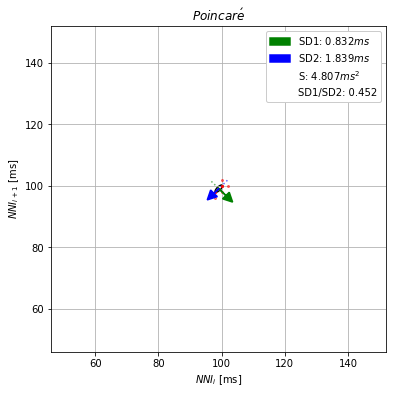

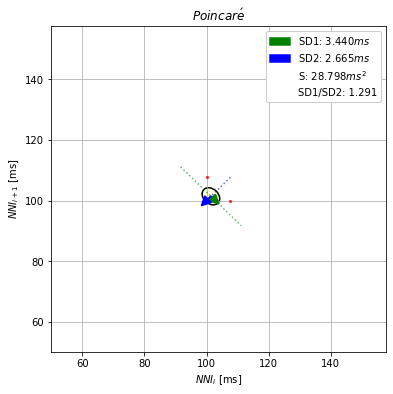

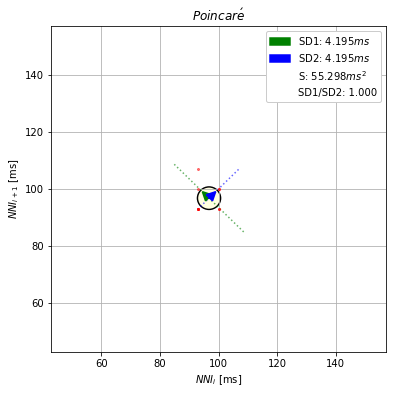

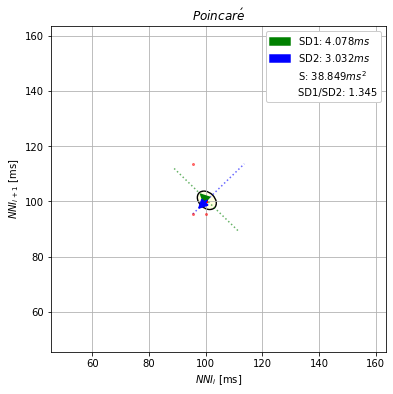

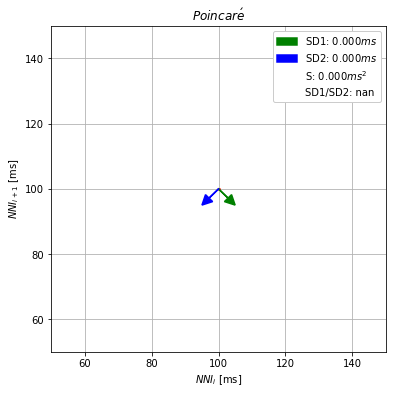

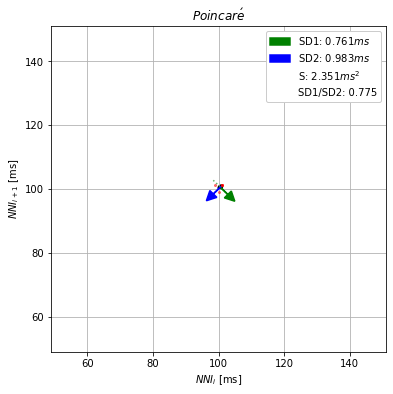

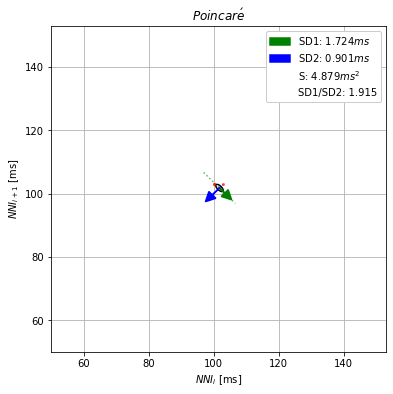

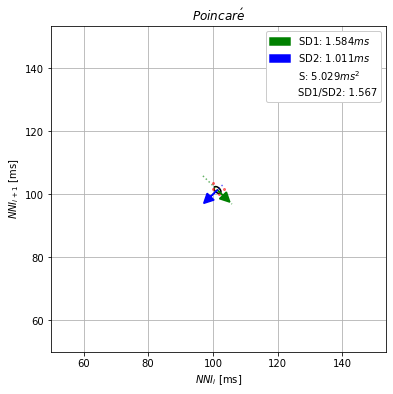

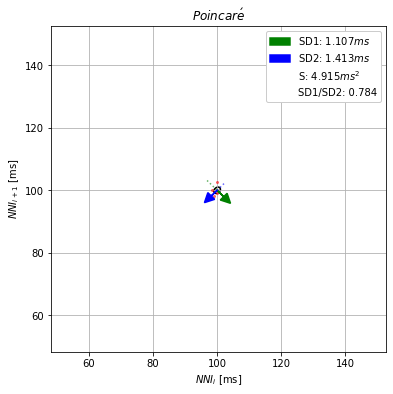

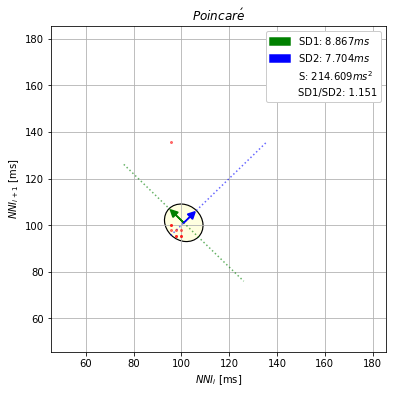

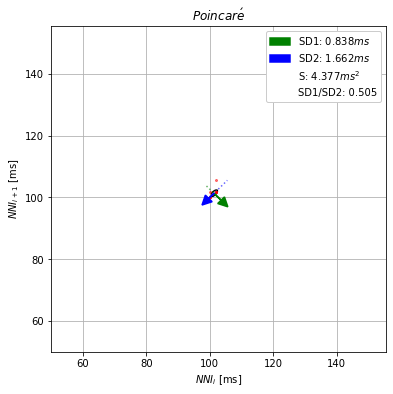

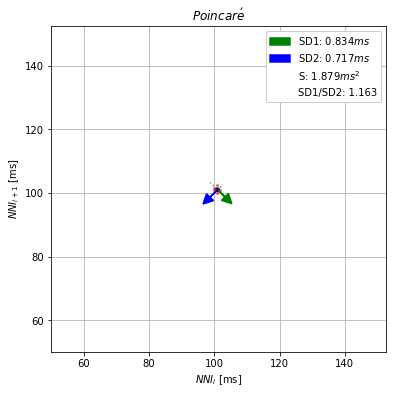

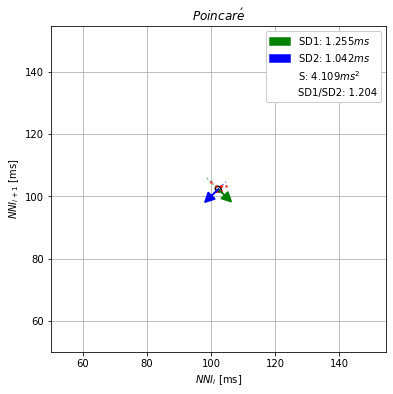

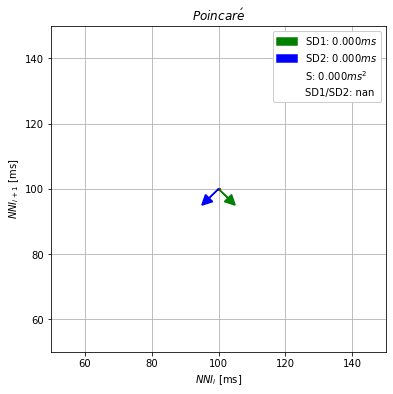

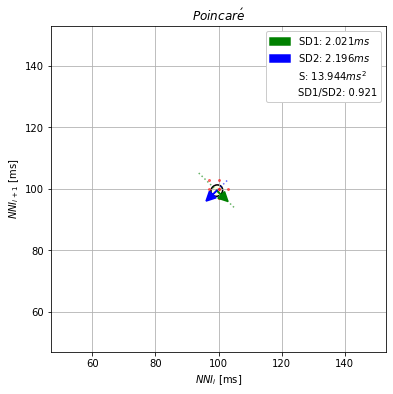

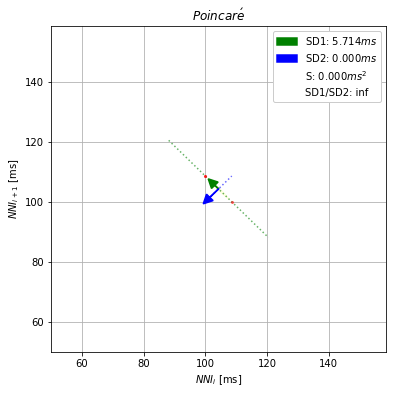

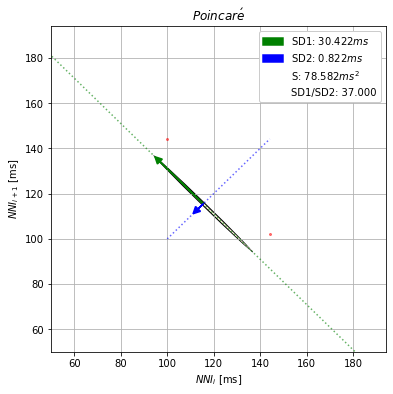

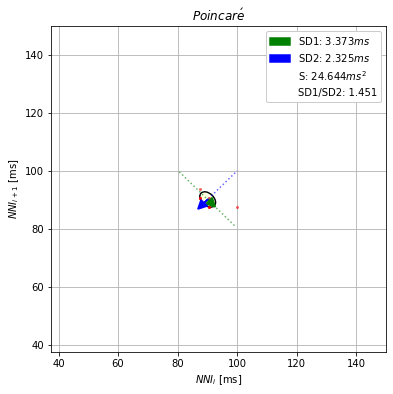

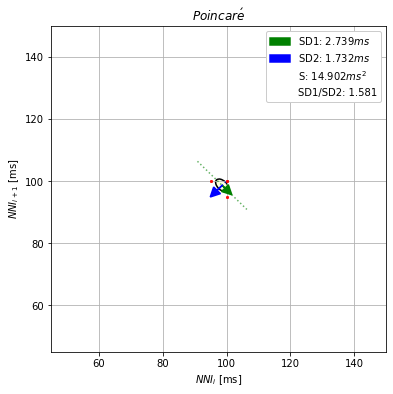

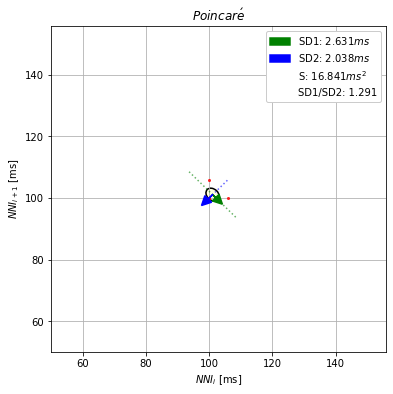

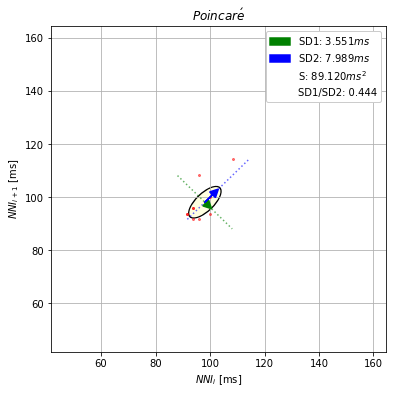

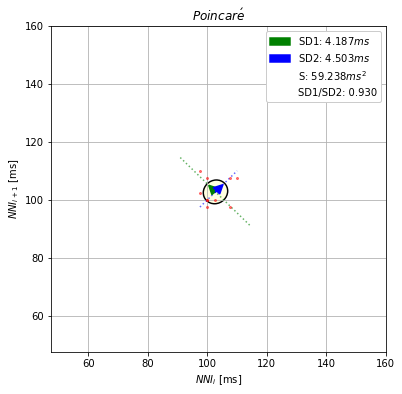

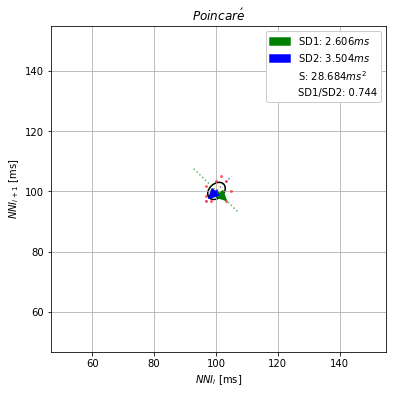

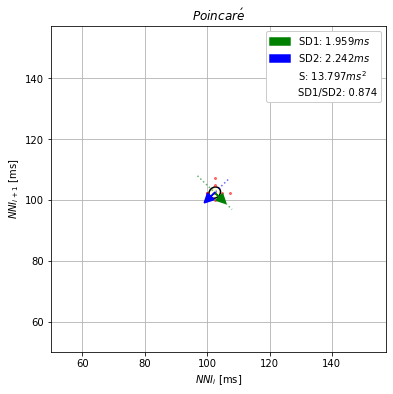

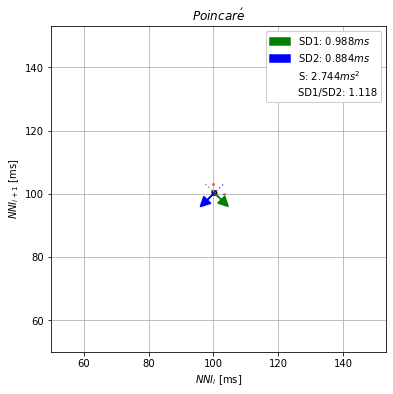

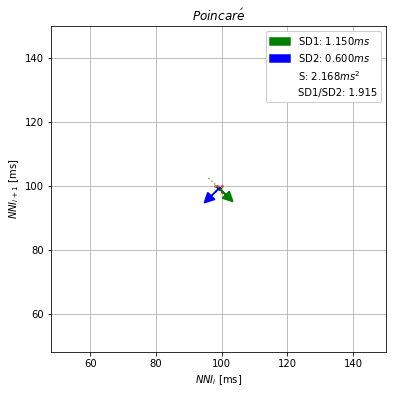

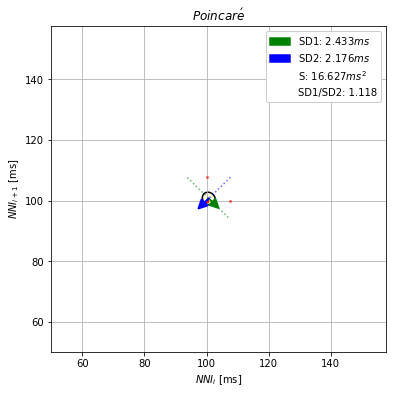

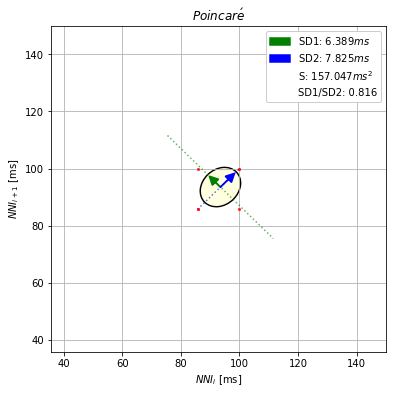

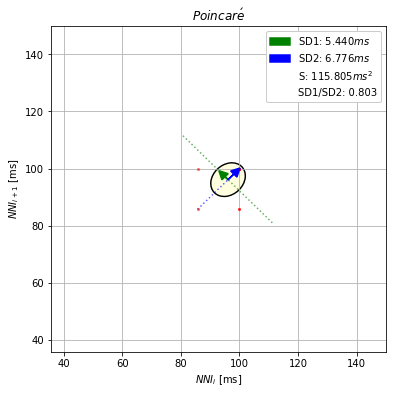

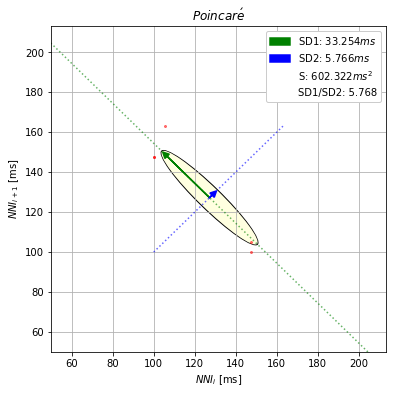

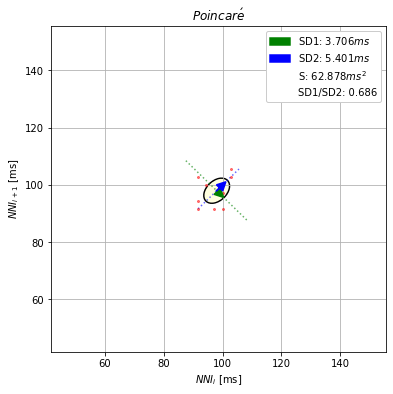

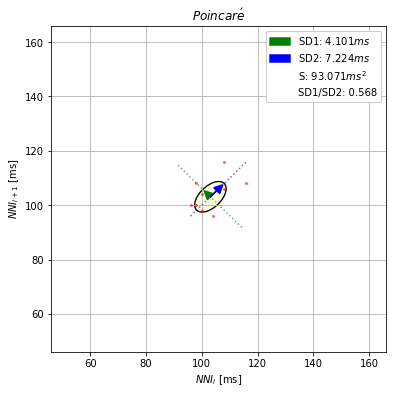

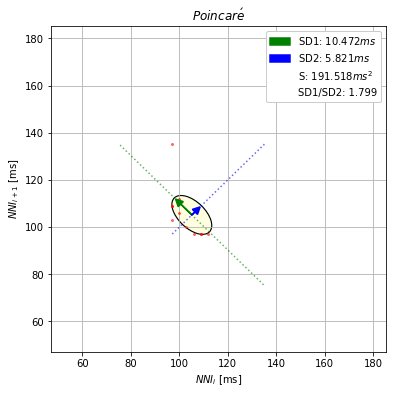

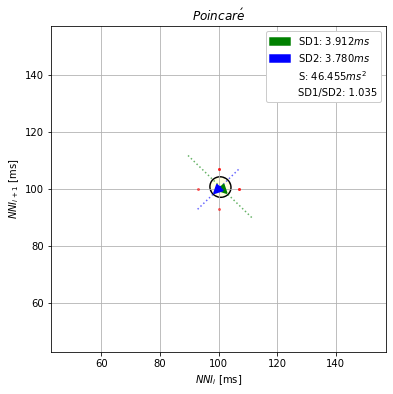

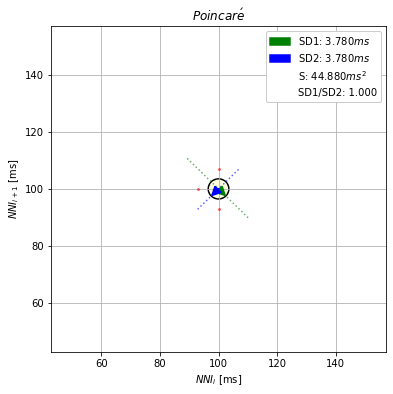

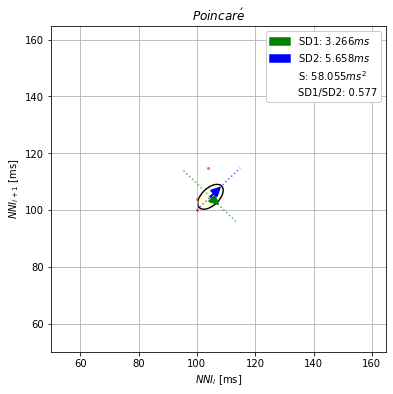

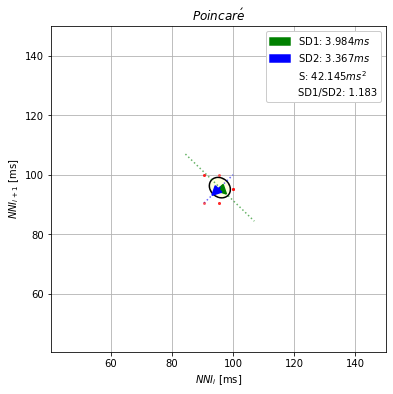

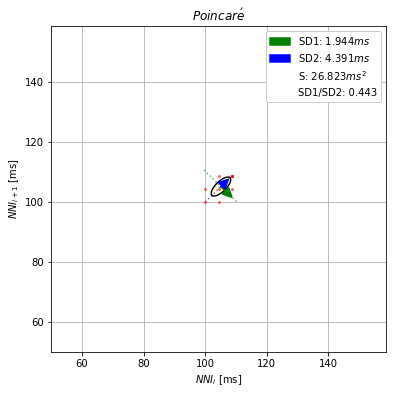

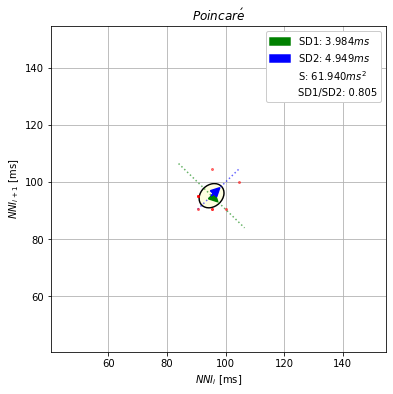

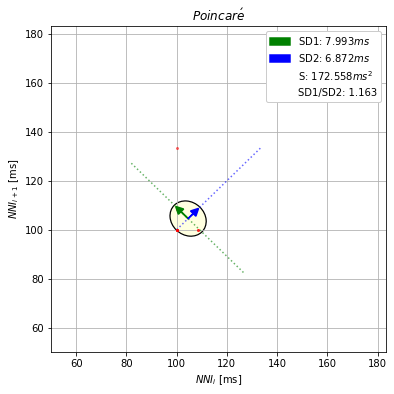

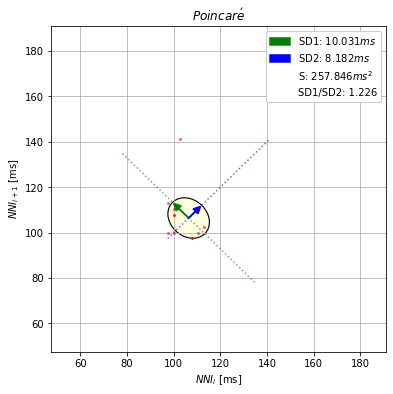

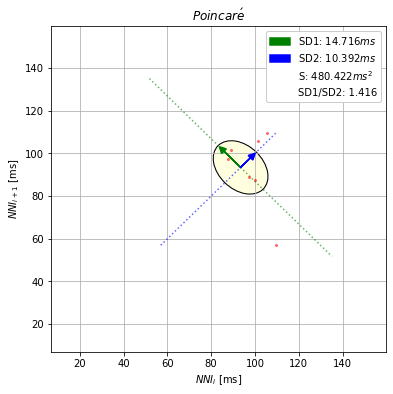

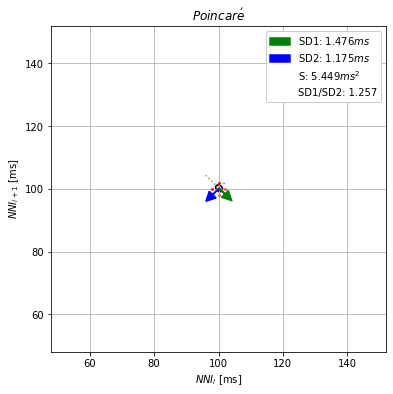

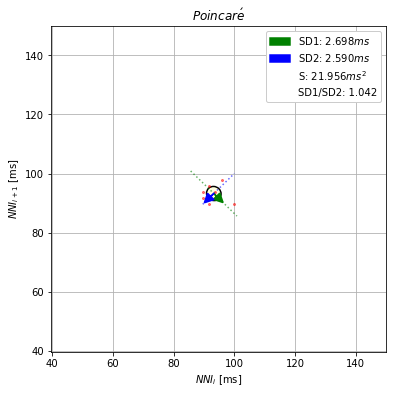

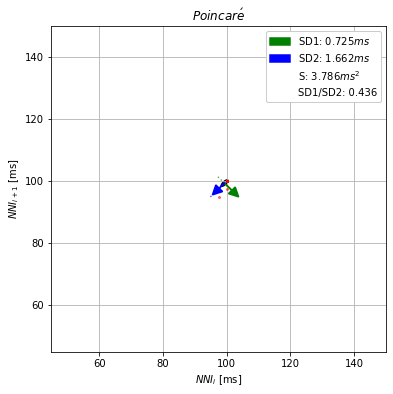

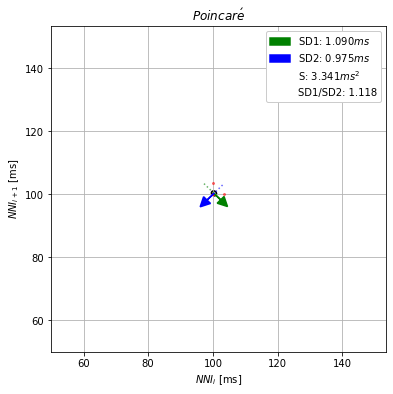

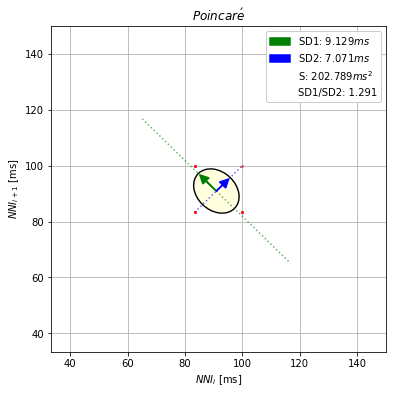

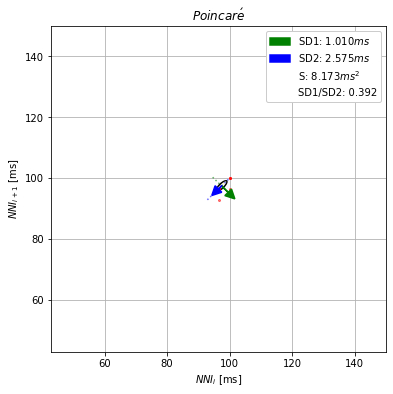

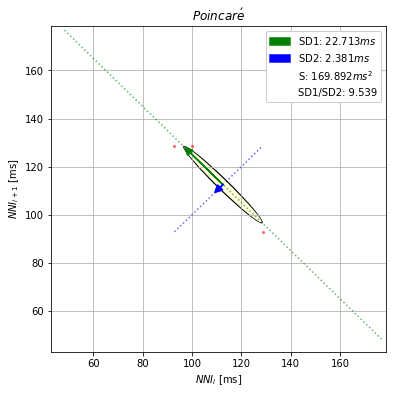

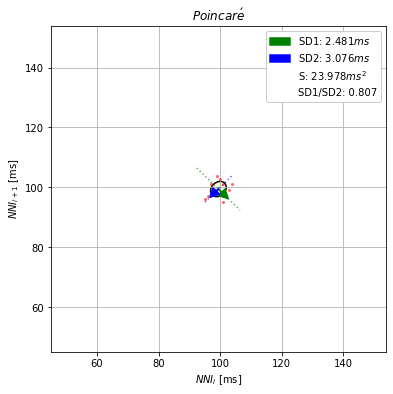

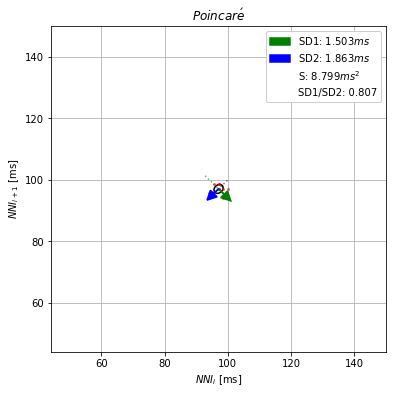

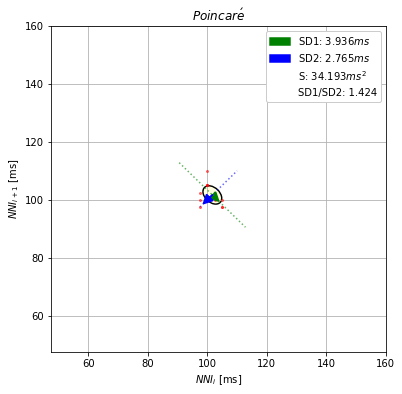

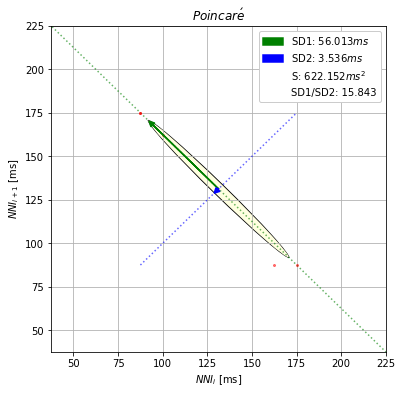

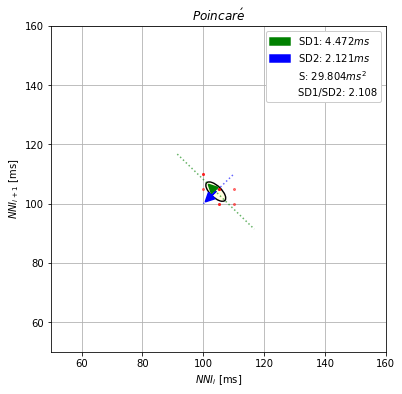

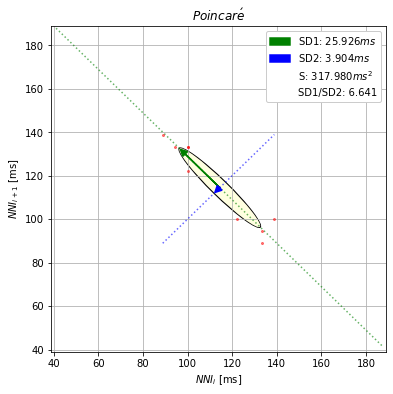

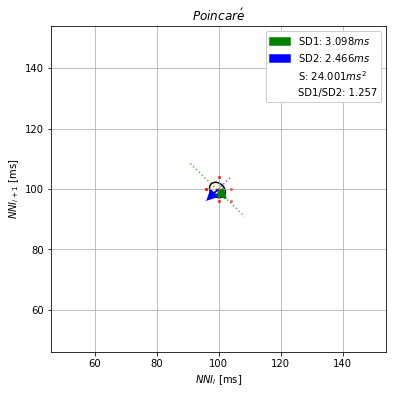

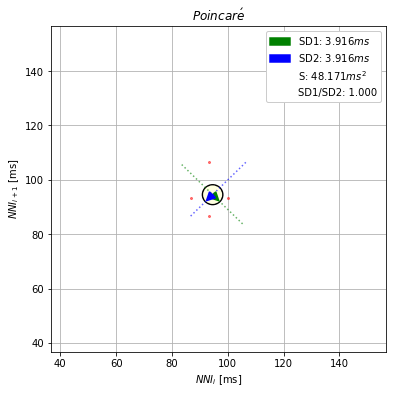

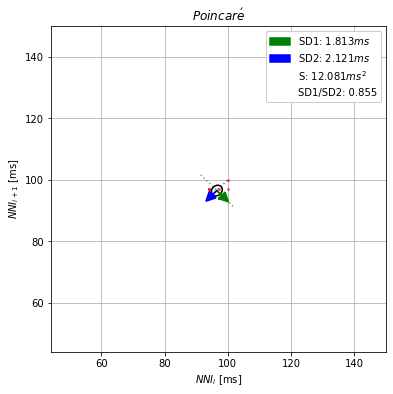

In [189]:
sd1 = []
sd2 = []
sd_ratio = []
for tabla in [tabulado_control5,tabulado_vk5,tabulado_dan5]:
    control_sd1 = []
    control_sd2 = []
    control_sd_ratio = []
    for i in range (len(tabla['mins'])):
        try:
            minimos = tabla['mins'][i]
            results = nl.poincare(minimos)
            control_sd1.append(results['sd1'])
            control_sd2.append(results['sd2'])
            control_sd_ratio.append(results[3])
        except:
            pass
    sd1.append(control_sd1)
    sd2.append(control_sd2)
    sd_ratio.append(control_sd_ratio)

In [194]:
for i in sd1:
    sd1_limpio = pd.DataFrame(i)#[outliers(pd.DataFrame(i))]
    print(sd1_limpio.median(),sd1_limpio.std())

0    2.357023
dtype: float64 0    5.398502
dtype: float64
0    3.845974
dtype: float64 0    6.920528
dtype: float64
0    3.507083
dtype: float64 0    13.859882
dtype: float64


In [198]:
scipy.stats.kstest(sd1[0],sd1[1])

KstestResult(statistic=0.3193548387096774, pvalue=0.13018327320042433)

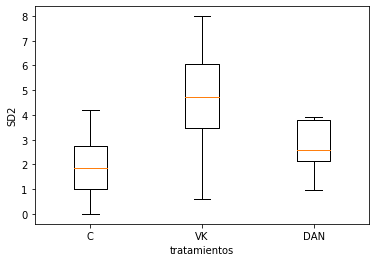

In [180]:
from matplotlib import pyplot

x = sd2[0]
y = sd2[1]
z = sd2[2]

fig = plt.figure()
pyplot.boxplot([x,y,z], 0,'')
pyplot.xlabel('tratamientos')
pyplot.xticks([1,2,3],['C','VK','DAN'])
pyplot.ylabel('SD2')
pyplot.show()
fig.savefig('SD2',dpi=300)

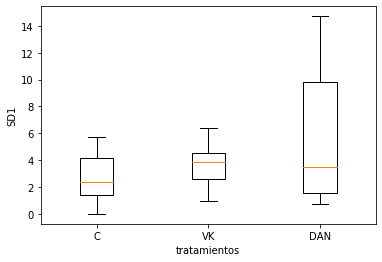

In [196]:
from matplotlib import pyplot

x = sd1[0]
y = sd1[1]
z = sd1[2]

fig = plt.figure()
pyplot.boxplot([x,y,z], 0,'')
pyplot.xlabel('tratamientos')
pyplot.xticks([1,2,3],['C','VK','DAN'])
pyplot.ylabel('SD1')
pyplot.show()
fig.savefig('SD1',dpi=300)

In [17]:
# tabulado_dan5.to_excel(path + 'mins_dan para poincare' + '.xlsx', engine='xlsxwriter')  

In [18]:
# tabulado_dan5.to_csv(path + 'mins_dan para poincare')

In [20]:
# tabulado_dan5 = pd.read_csv(path + 'mins_dan para poincare')

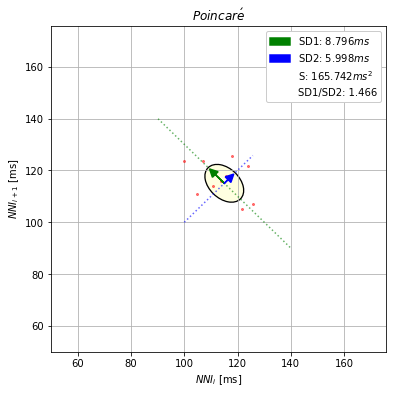

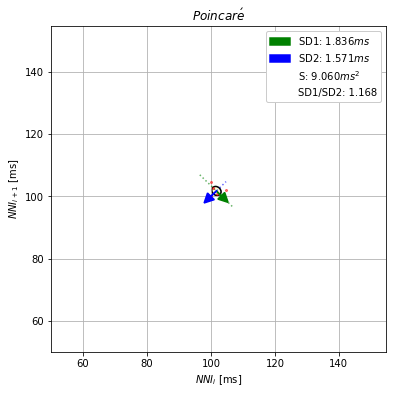

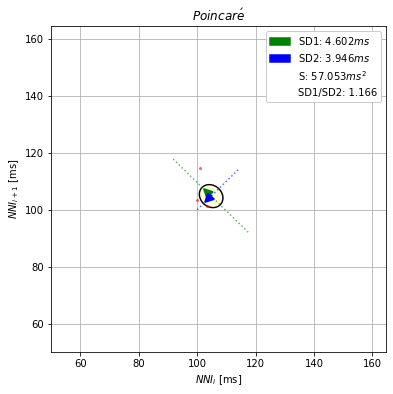

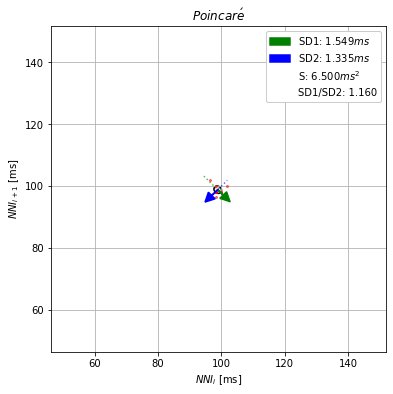

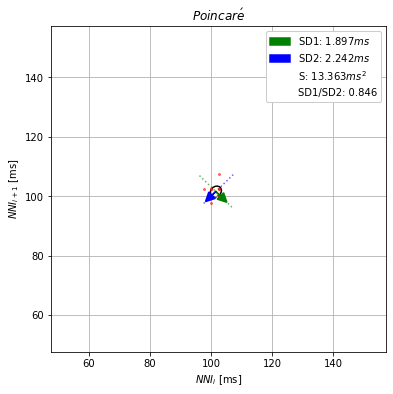

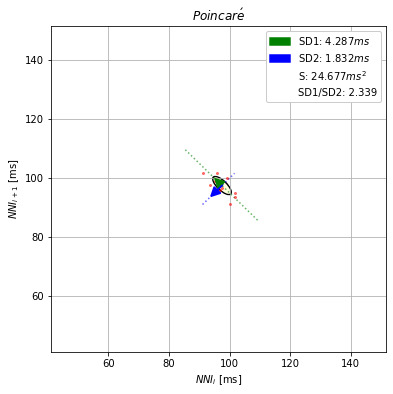

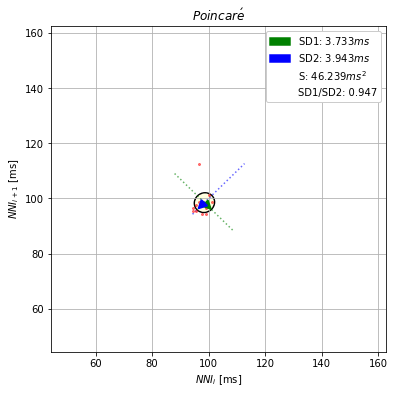

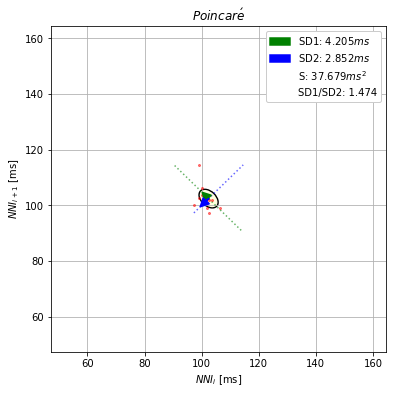

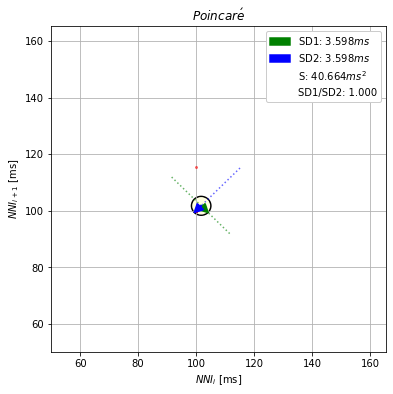

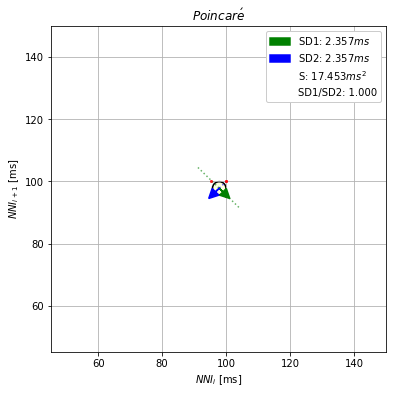

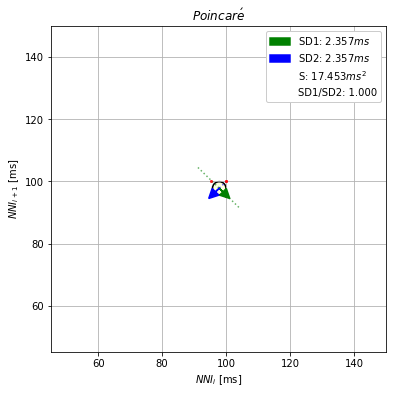

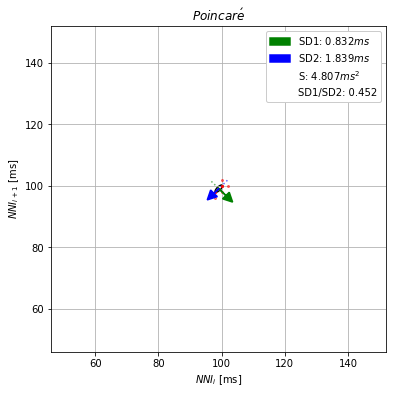

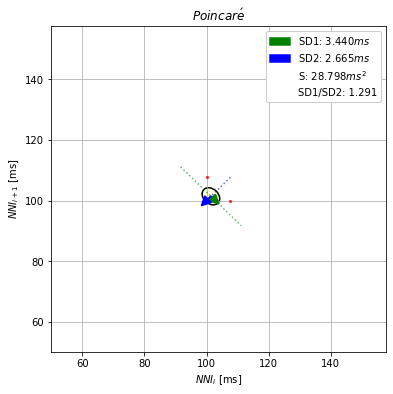

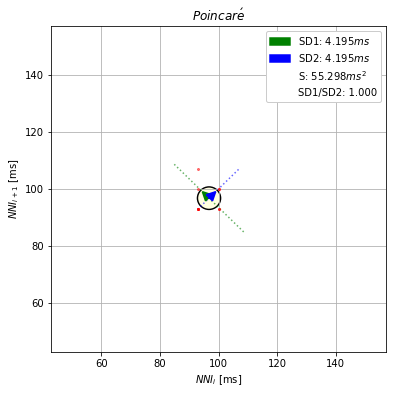

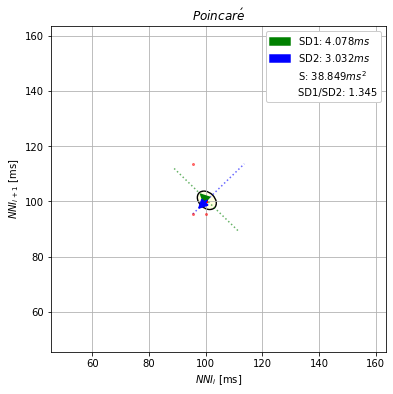

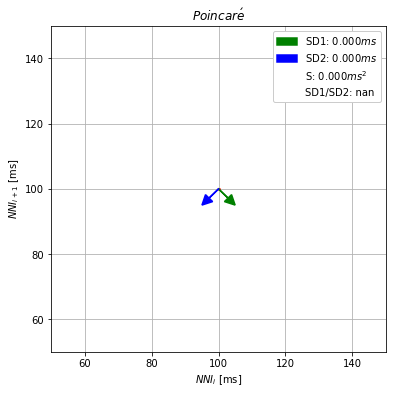

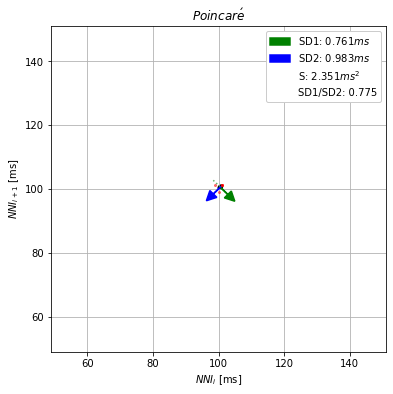

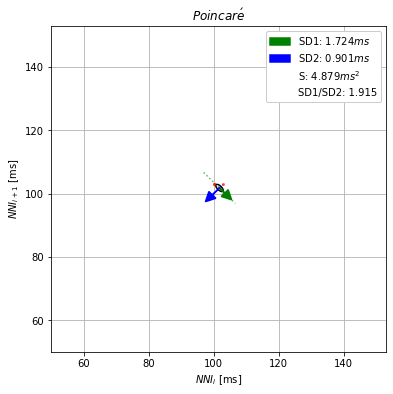

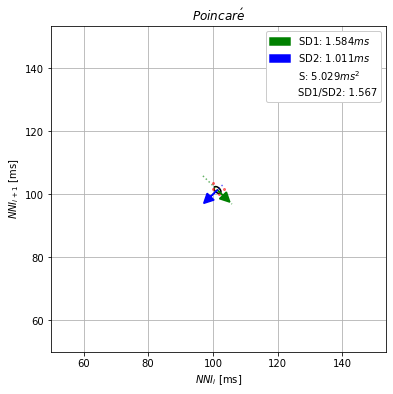

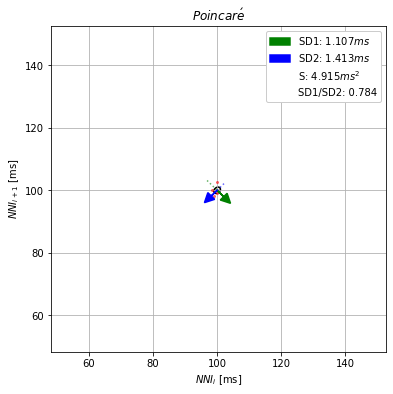

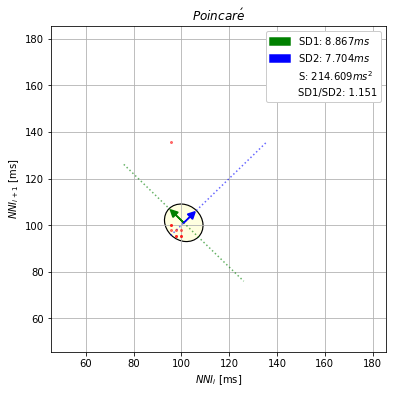

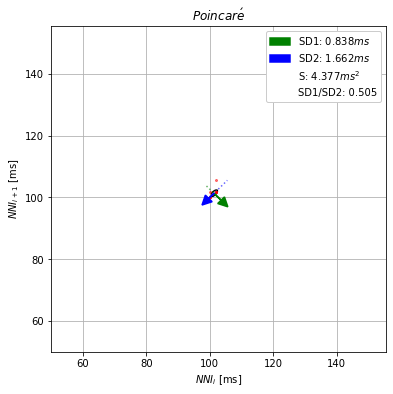

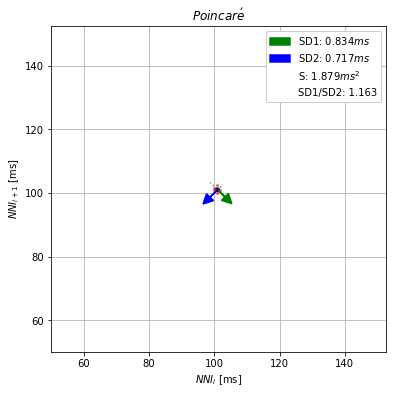

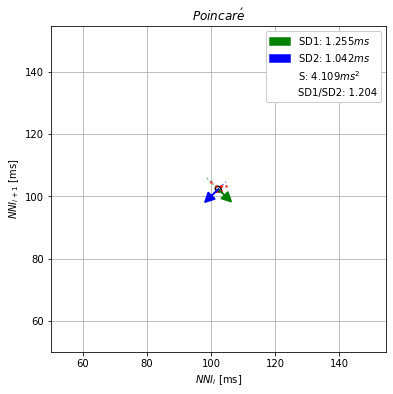

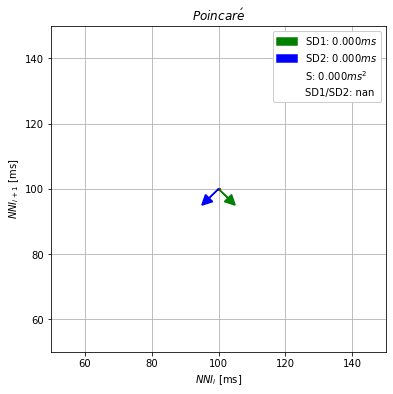

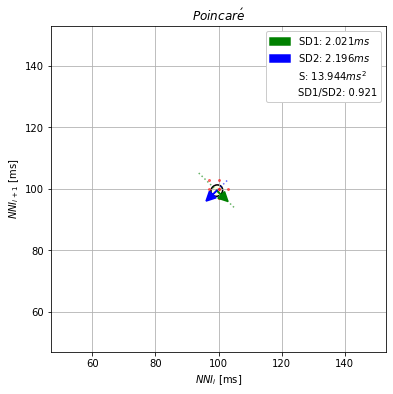

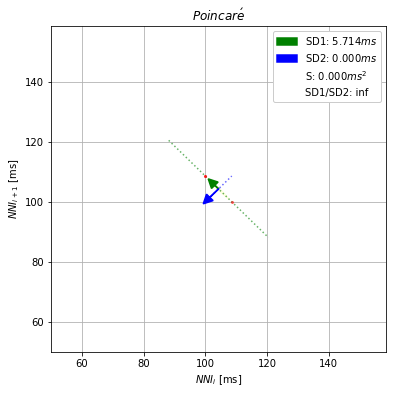

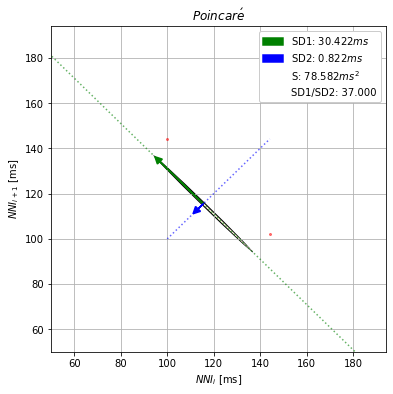

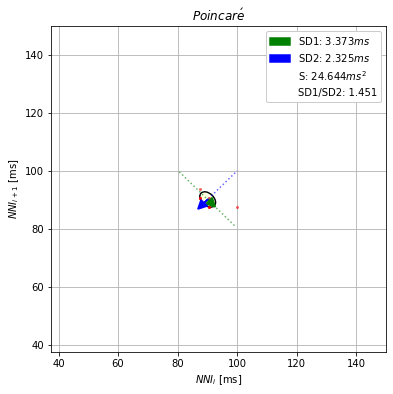

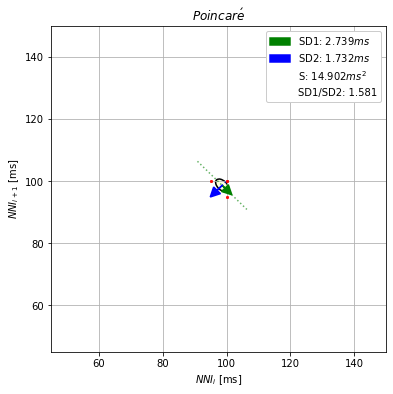

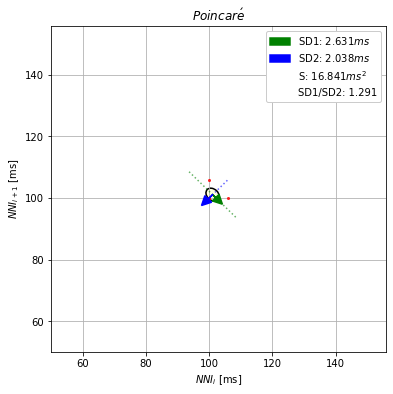

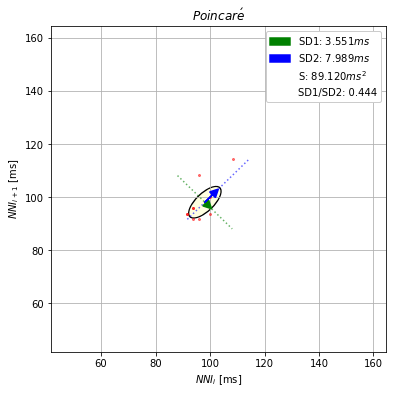

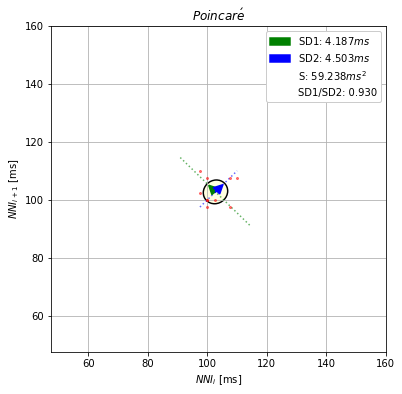

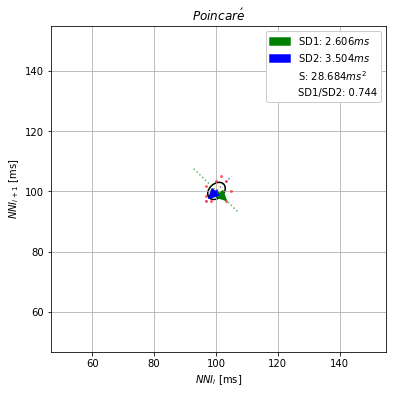

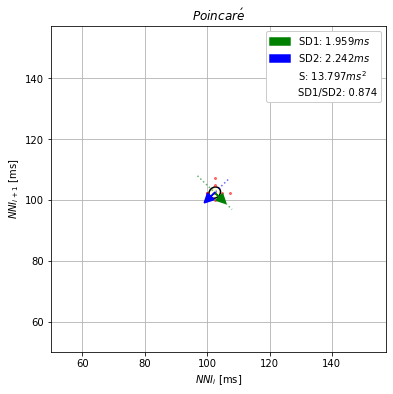

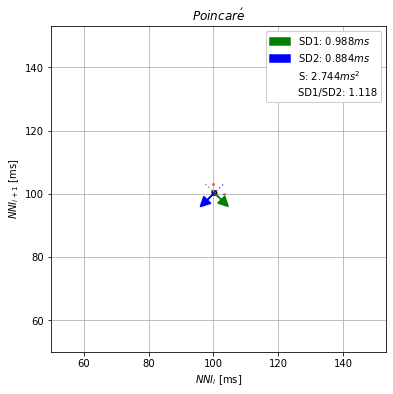

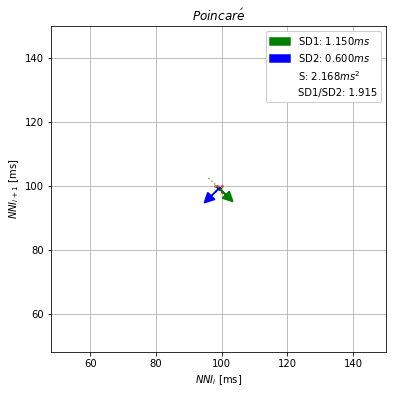

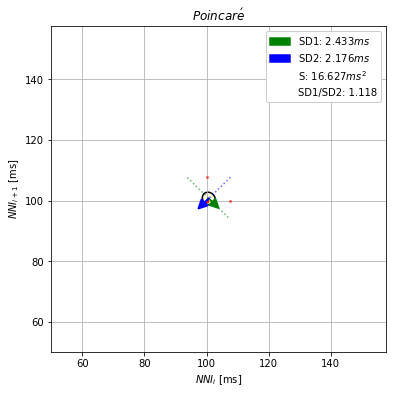

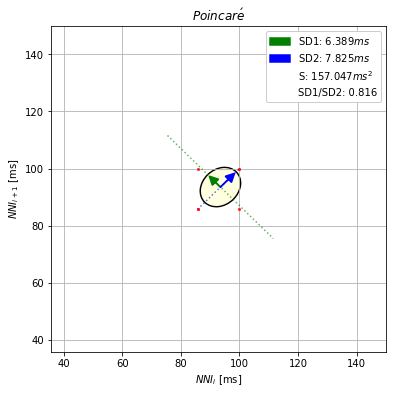

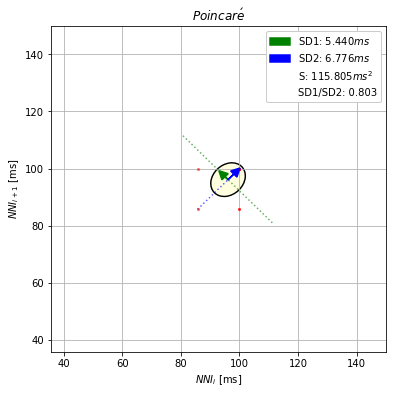

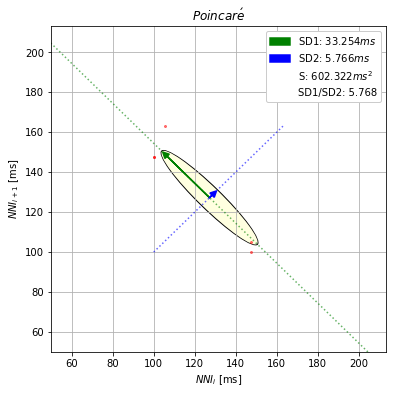

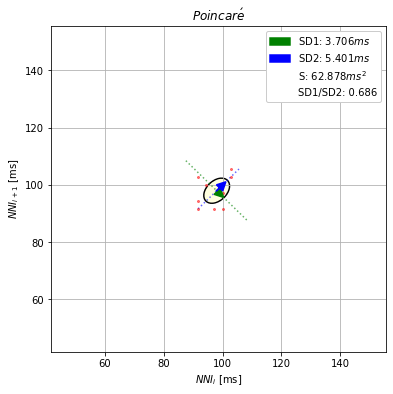

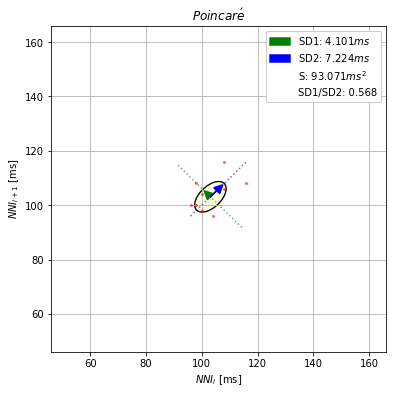

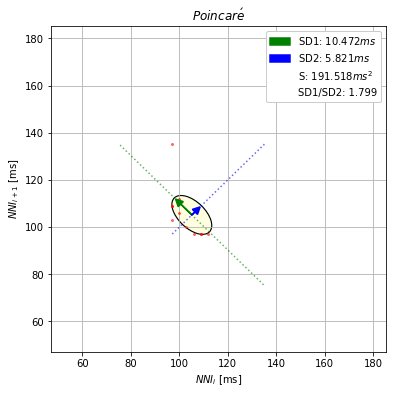

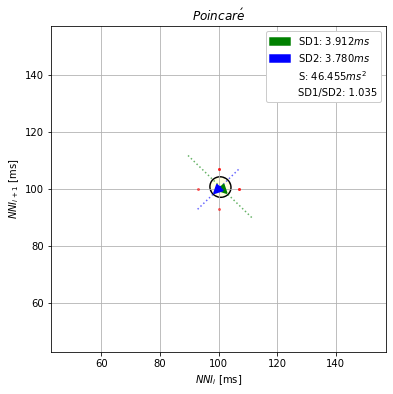

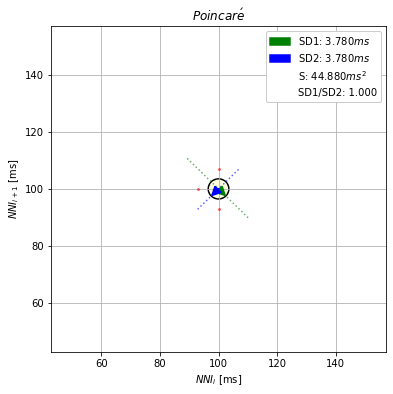

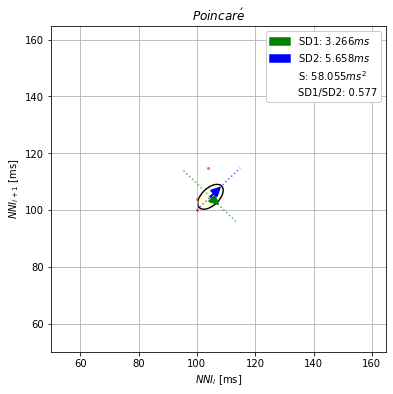

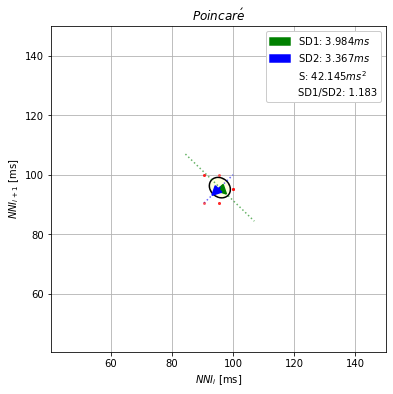

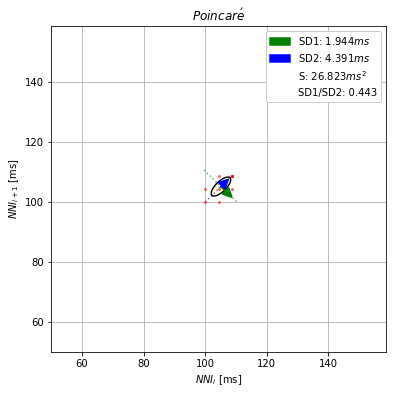

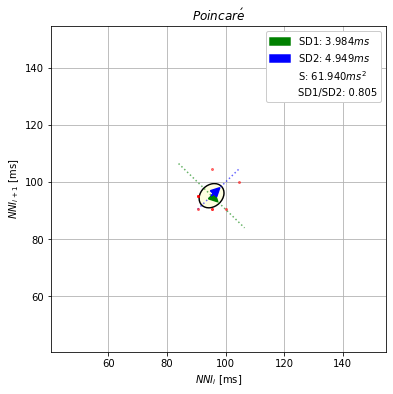

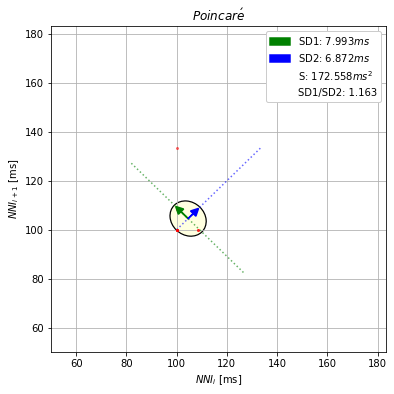

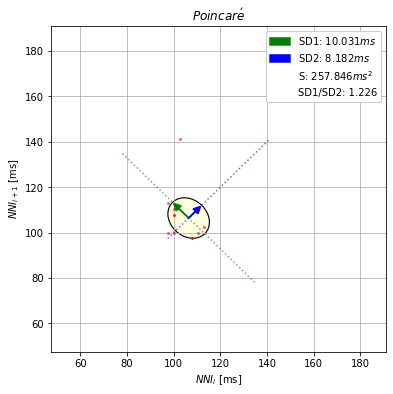

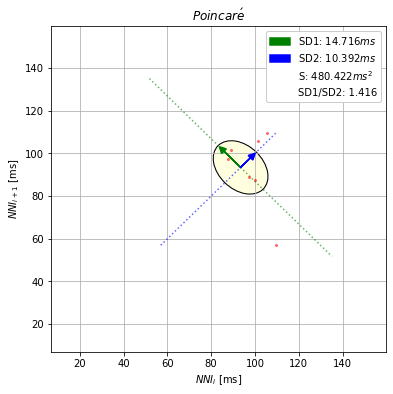

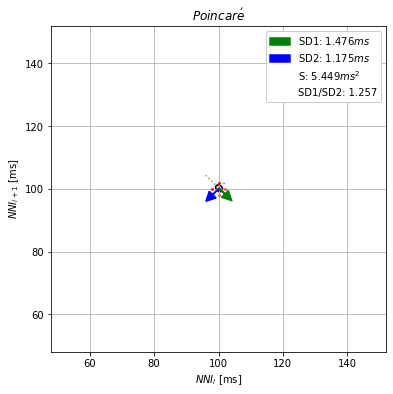

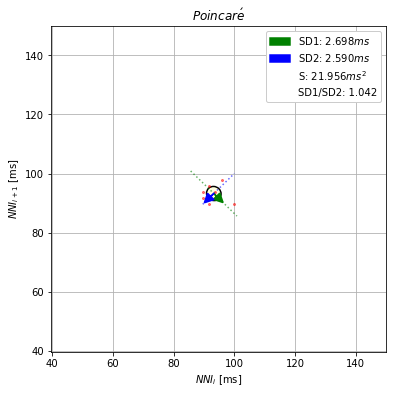

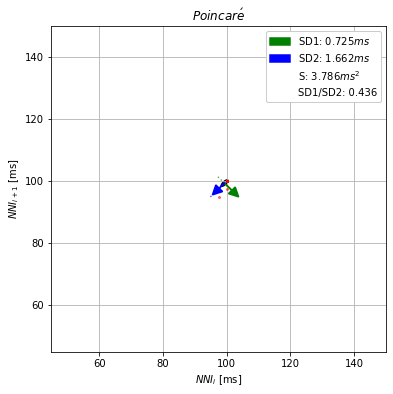

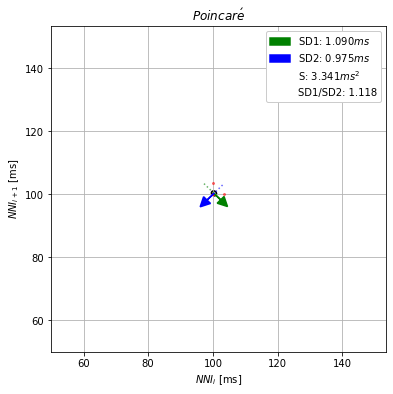

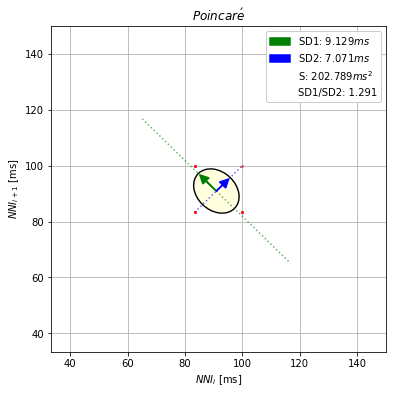

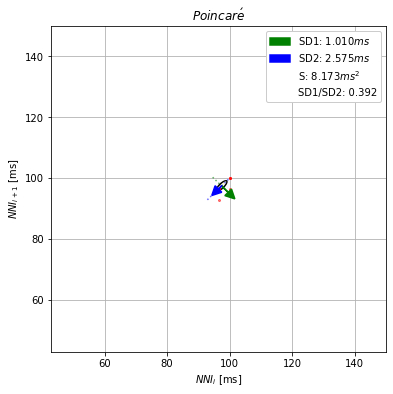

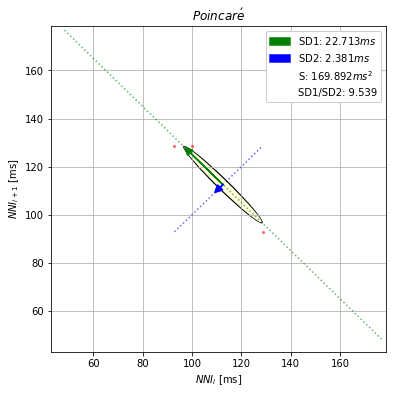

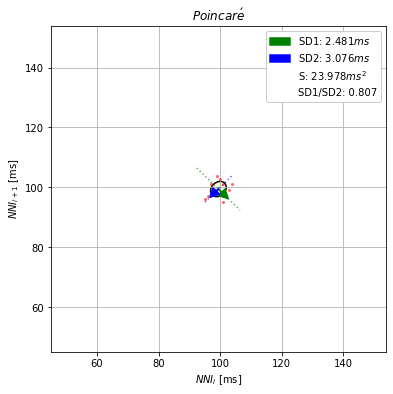

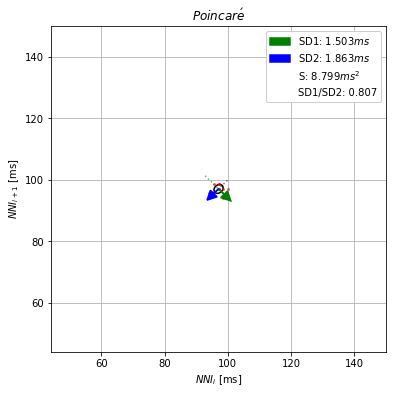

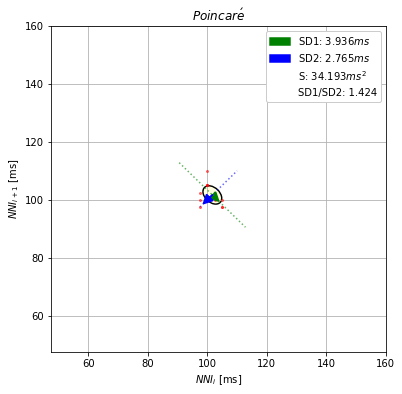

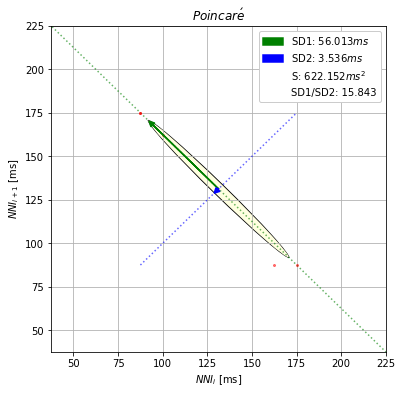

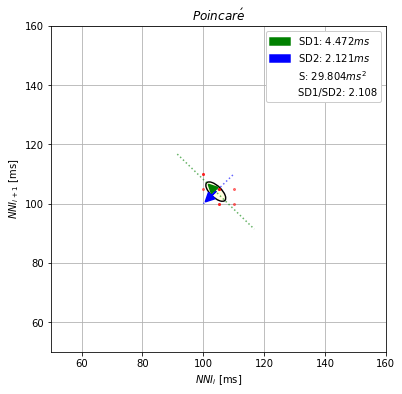

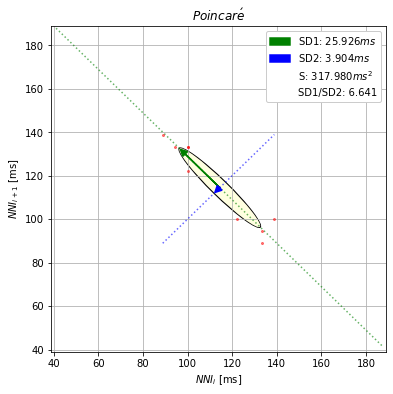

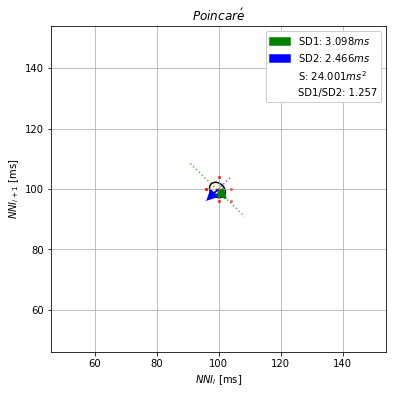

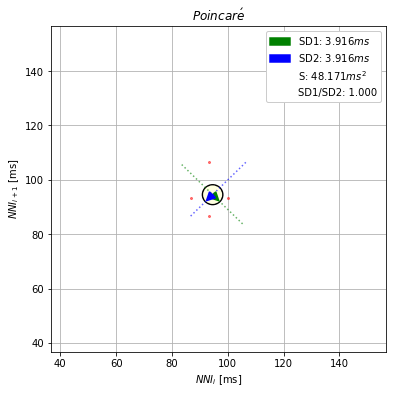

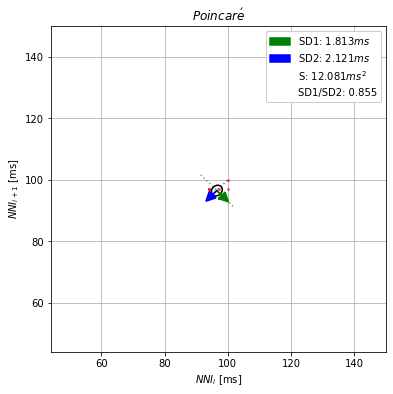

In [182]:
sd1 = []
sd2 = []
sd_ratio = []
length = len(tabulado_control5['mins'])
for tabla in [tabulado_control5,tabulado_vk5,tabulado_dan5]:
    control_sd1 = []
    control_sd2 = []
    control_sd_ratio = []
    for i in range (length):
        try:
            minimos = tabla['mins'][i]
            file = tabla['file'][i]
            results = nl.poincare(minimos)
            control_sd1.append([file,results['sd1']])
            control_sd2.append([file,results['sd2']])
            control_sd_ratio.append([file,results[3]])
        except:
            control_sd1.append([None,None])
            control_sd2.append([None,None])
            control_sd_ratio.append([None,None])            
    sd1.append(control_sd1)
    sd2.append(control_sd2)
    sd_ratio.append(control_sd_ratio)

In [183]:
df_sd1 = pd.DataFrame(sd1).T
df_sd2 = pd.DataFrame(sd2).T

In [184]:
df_control = pd.DataFrame({'file':pd.DataFrame(df_sd1[0].values.tolist())[0],'sd1':pd.DataFrame(df_sd1[0].values.tolist())[1],'sd2':pd.DataFrame(df_sd2[0].values.tolist())[1]})
df_vk = pd.DataFrame({'file':pd.DataFrame(df_sd1[1].values.tolist())[0],'sd1':pd.DataFrame(df_sd1[1].values.tolist())[1],'sd2':pd.DataFrame(df_sd2[1].values.tolist())[1]})
df_dan = pd.DataFrame({'file':pd.DataFrame(df_sd1[2].values.tolist())[0],'sd1':pd.DataFrame(df_sd1[2].values.tolist())[1],'sd2':pd.DataFrame(df_sd2[2].values.tolist())[1]})

In [201]:
df_control.to_excel(path + 'df_control' + '.xlsx', engine='xlsxwriter')  

### Correlación SD vs DI

In [95]:
path = 'C:/Users/Leand/OneDrive/Documentos/Lean/Analizador_imagenes_calcio/Luis/analisis/'
DI_control = pd.read_csv(path + 'DI_control.csv')
DI_vk = pd.read_csv(path + 'DI_vk.csv')
DI_dan = pd.read_csv(path + 'DI_dan.csv')
df_control = pd.read_excel(path + 'df_control.xlsx')
df_vk = pd.read_excel(path + 'df_vk.xlsx')
df_dan = pd.read_excel(path + 'df_dan.xlsx')

In [96]:
def filtro_SD_DI(tabla_DI,tabla_SD):
    SD_DI = []
    for i in range(0,len(tabla_DI['file'])):
        cel = tabla_DI['file'][i]
        filtro = tabla_SD[(tabla_SD['file'].str.contains(cel) == True)]
        filtro['DI_5Hz'] = tabla_DI['DISCORDANCE 5 Hz'][i]
        del filtro['Unnamed: 0']
        SD_DI.append (filtro.values.tolist())
    return SD_DI,

In [109]:
SD_DI_control = filtro_SD_DI(DI_control,df_control)
sd_di_control = pd.DataFrame (SD_DI_control).T
x = pd.DataFrame(sd_di_control[0].to_list(), columns=['file','SD'])['file'].dropna()
x = pd.DataFrame(x.to_list(), columns=['file','SD1','SD2','DI'])

C:\Users\Leand\PyMOL\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Leand\PyMOL\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Leand\PyMOL\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [107]:
SD_DI_vk = filtro_SD_DI(DI_vk,df_vk)
sd_di_vk = pd.DataFrame (SD_DI_vk).T
y = pd.DataFrame(sd_di_vk[0].to_list(), columns=['file'])['file'].dropna()
y = pd.DataFrame(y.to_list(), columns=['file','SD1','SD2','DI'])

C:\Users\Leand\PyMOL\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [110]:
SD_DI_dan = filtro_SD_DI(DI_vk,df_vk)
sd_di_dan = pd.DataFrame (SD_DI_dan).T
z = pd.DataFrame(sd_di_dan[0].to_list(), columns=['file'])['file'].dropna()
z = pd.DataFrame(z.to_list(), columns=['file','SD1','SD2','DI'])

C:\Users\Leand\PyMOL\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(0.2019842570765378, 0.16398825082467522)


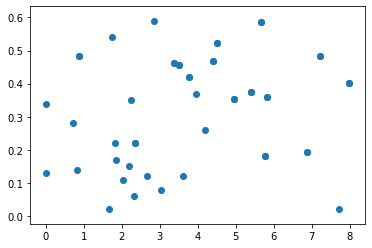

In [121]:
w = pd.concat([x,y,z], axis=0)
a = w['SD2'] 
b = w['DI']

print (pearsonr(a,b))
plt.scatter(a,b)

In [105]:
x

,file,SD1,SD2,DI
0,010719VK3_analysis_result_vk3b002.json,3.550846,7.988979,0.403029
1,010719VK7_analysis_result_vk7a000.json,4.187034,4.503471,0.523415
2,170719VK4_analysis_result_vk4b000.json,10.472276,5.821268,0.359029
3,170719VK7_analysis_result_vk7b000.json,4.101219,7.223573,0.484608
4,230819VK1_analysis_result_vk1d000.json,1.944407,4.391089,0.467583
5,230819VK2_analysis_result_vk2d000.json,3.984095,3.367175,0.463743
6,031019c2_analysis_result_c2f000.json,2.605787,3.503868,0.457584
7,031019c5_analysis_result_c5E000.json,0.988212,0.883883,0.484874
8,171019vk3_analysis_result_vk3e000.json,3.779645,3.779645,0.420581
9,311019vk2_analysis_result_vk2d000.json,7.993053,6.871843,0.192759
